# Multi-cloudtype 
In this notebook, a model that will predict the mask for all four cloud types is looked at.  

In [76]:
import sys
sys.path.append('/home/jupyter/fastai_dev/dev')
from local.data.all import *
from local.vision.all import *
from local.vision.core import *
from local.vision.augment import *
from local.vision import models
from local.basics import *

## Data

In [2]:
CATS = ['fish', 'flower', 'gravel', 'sugar']

### Load the images' file paths and the annotations

In [3]:
SOURCE = Path('data/train_images/')

In [4]:
items = get_image_files(SOURCE)

In [15]:
items[11]

PosixPath('data/train_images/eba901f.jpg')

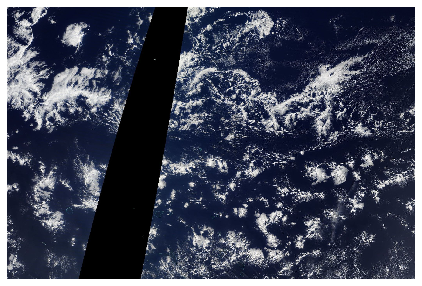

In [14]:
PILImage.create(items[11]).show(figsize=(10, 5));

In [16]:
IMG_SHAPE = PILImage.create(items[12]).shape
IMG_SHAPE

(1400, 2100)

In [6]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [7]:
annots = load_train_annotation('data/train.csv')

In [18]:
annots.head()

,Image,Label,EncodedPixels
0,0011165,fish,264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 937 277518 937 278918 937 280318 937 281718 937 283118 937 284518 937 285918 937 287318 937 288718 937 290118 937 291518 937 292918 937 294318 937 295718 937 297118 937 298518 937 299918 937 301318 937 302718 937 304118 937 305518 937 306918 937 308318 937 309718 937 311118 937 312518 937 313918 937 315318 937 316718 937 318118 937 319518 937 320918 937 322318 937 323718 937 325118 937 326518 937 327918 937 329318 937 330718 937 332118 937 333518 937 334918 937 336318 937 337718 937 339118 937 34...
1,0011165,flower,1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 1365365 1002 1366765 1002 1368165 1002 1369565 1002 1370965 1002 1372365 1002 1373765 1002 1375165 1002 1376565 1002 1377965 1002 1379365 1002 1380765 1002 1382165 1002 1383565 1002 1384965 1002 1386365 1002 1387765 1002 1389165 1002 1390565 1002 1391965 1002 1393365 1002 1394765 1002 1396165 1002 1397565 1002 1398965 1002 1400365 1002 1401765 1002 1403165 1002 1404565 1002 1405965 1002 1407365 1002 1408765 1002 1410165 1002 1411565 1002 1412965 1002 1414365 1002 1415765 1002 1417165 1002 1418565 100...
2,0011165,gravel,NaN
3,0011165,sugar,NaN
4,002be4f,fish,233813 878 235213 878 236613 878 238010 881 239410 881 240810 881 242210 881 243610 881 245010 881 246410 881 247810 881 249210 881 250610 881 252010 881 253410 881 254810 881 256210 881 257610 881 259010 881 260410 881 261810 881 263210 881 264610 881 266010 881 267410 881 268810 881 270210 881 271610 881 273010 881 274410 881 275810 881 277210 881 278610 881 280010 881 281410 881 282810 881 284210 881 285610 881 287010 881 288410 881 289810 881 291210 881 292610 881 294010 881 295410 881 296810 881 298210 881 299610 881 301010 881 302410 881 303810 881 305210 881 306610 881 308010 881 30...


### Rescaling the images
The original size of the images is 2100 px in width and 1400 px in height.  To start off with something smaller, a `Transform` is created for rescaling the images.  Here, the aspect ratio is kept the same, so no cropping or squishing.

In [19]:
class RescaleTfm(TupleTransform):
    def __init__(self, max_w=210, resample=Image.BILINEAR): 
        self.max_w, self.resample = max_w, resample
        
    def encodes(self, o:PILImage): return o.resize_max(max_w=self.max_w, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize_max(max_w=self.max_w, resample=Image.NEAREST)

In [20]:
SZ = 210

### Decode Run-length Encoding

In [21]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [22]:
class RLE_Decode(Transform):
    def __init__(self, cat, annots, img_shape): 
        self.cat, self.annots, self.img_shape = cat,  annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        px_rle = df[df.Label == self.cat].EncodedPixels.values[0]
        return rle_decode(px_rle, IMG_SHAPE)

In [23]:
annots[annots.Image == items[16].stem]

,Image,Label,EncodedPixels
10464,76ee28f,fish,659 452 2059 452 3459 452 4859 452 6259 452 7659 452 9059 452 10459 452 11859 452 13259 452 14659 452 16059 452 17459 452 18859 452 20259 452 21659 452 23059 452 24459 452 25859 452 27259 452 28659 452 30059 452 31459 452 32859 452 34259 452 35659 452 37059 452 38459 452 39859 452 41259 452 42659 452 44059 452 45459 452 46859 452 48259 452 49659 452 51059 452 52459 452 53859 452 55259 452 56659 452 58059 452 59459 452 60859 452 62259 452 63659 452 65059 452 66459 452 67859 452 69259 452 70659 452 72059 452 73459 452 74859 452 76259 452 77659 452 79059 452 80459 452 81859 452 83259 452 8465...
10465,76ee28f,flower,NaN
10466,76ee28f,gravel,NaN
10467,76ee28f,sugar,NaN


In [24]:
for cat in CATS: print(cat, RLE_Decode(cat, annots, IMG_SHAPE)(items[16]).sum())

fish 836662
flower 0
gravel 0
sugar 0


### DataSource

In [25]:
def to_pilmask(o): return PILMask.create(o)

In [26]:
class Tensor2MaskTfm(TupleTransform):
    def encodes(self, o): return PILMask.create(o)

In [27]:
split_idx = RandomSplitter()(items)
tensor2mask = Tensor2MaskTfm()

tfms = [[PILImage.create], 
        [RLE_Decode('fish', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('flower', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('gravel', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('sugar', annots, IMG_SHAPE), tensor2mask]]

dsrc = DataSource(items, tfms=tfms, splits=split_idx, n_inp=1)

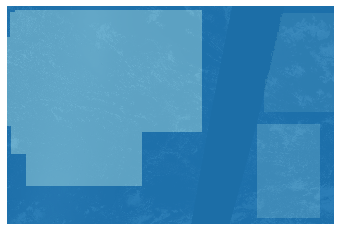

In [29]:
dsrc.show(dsrc[18]);

In [30]:
dsrc[18]

(<local.vision.core.PILImage image mode=RGB size=2100x1400 at 0x7F6011F7D6D0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x7F6011F97CD0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x7F6011F68650>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x7F6011F6F5D0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x7F6011F68B10>)

### DataBunch

In [31]:
rescale = RescaleTfm(max_w=SZ, resample=0)

In [32]:
rescale(dsrc[3])

(<local.vision.core.PILImage image mode=RGB size=210x140 at 0x7F6011F03950>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x7F6011F03250>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x7F6011F0BC90>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x7F6011F0B410>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x7F6011F0B650>)

In [33]:
after_item_tfms = [rescale, ToTensor]

In [34]:
after_batch_tfms = [Cuda(), IntToFloatTensor()]

In [35]:
dbch = dsrc.databunch(after_item=after_item_tfms, after_batch=after_batch_tfms, bs=8)

In [36]:
xb, *yb = dbch.one_batch()

In [37]:
len(yb)

4

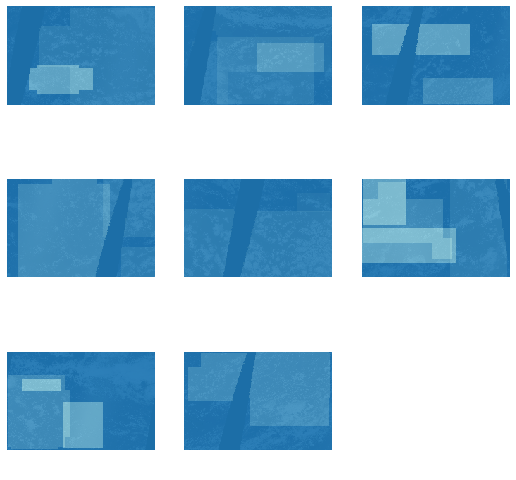

In [38]:
dbch.show_batch()

### Normalize

In [39]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [40]:
normalize = Normalize(*imagenet_stats)

Re-create `DataBunch`, adding `Normalize` transform:

In [41]:
after_item_tfms = [rescale, ToTensor]
after_batch_tfms = [Cuda(), IntToFloatTensor(), normalize]

In [42]:
dbch = dsrc.databunch(after_item=after_item_tfms, bs=8, after_batch=after_batch_tfms)

In [43]:
xb, *yb = dbch.one_batch()

In [44]:
xb.shape

torch.Size([8, 3, 140, 210])

In [45]:
for yb_ in yb: print(yb_.shape)

torch.Size([8, 140, 210])
torch.Size([8, 140, 210])
torch.Size([8, 140, 210])
torch.Size([8, 140, 210])


## Model


In [46]:
xb.shape, yb[0].shape, yb[1].shape, yb[2].shape

(torch.Size([8, 3, 140, 210]),
 torch.Size([8, 140, 210]),
 torch.Size([8, 140, 210]),
 torch.Size([8, 140, 210]))

In [49]:
encoder = models.resnet34(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-2])

In [50]:
model = models.unet.DynamicUnet(encoder=encoder, n_classes=2, img_size=xb.shape[-2:], norm_type=None)


In [53]:
model.cuda();

In [54]:
pred = model(xb)

In [55]:
pred.shape

torch.Size([8, 2, 140, 210])

In [56]:
model[-1][0].in_channels, model[-1][0].out_channels, model[-1][0].kernel_size

(99, 2, (1, 1))

In [57]:
model[-1]

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [58]:
ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [59]:
CATS

['fish', 'flower', 'gravel', 'sugar']

In [60]:
class CloudsCustomHead(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv_clouds = [ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None) for _ in CATS]
        self.conv_fish = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_flower = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_gravel = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_sugar = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
                
    def forward(self, o):
        #return tuple(m(o) for m in self.conv_clouds)
        return self.conv_fish(o), self.conv_flower(o), self.conv_gravel(o), self.conv_sugar(o)

In [61]:
custom_head = CloudsCustomHead()
custom_head

CloudsCustomHead(
  (conv_fish): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_flower): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_gravel): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_sugar): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [62]:
layers = list(model[:-1]) + [custom_head]

In [63]:
model = SequentialEx(*layers)

In [66]:
model.cuda()

SequentialEx(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [67]:
y_test = model(xb)

In [68]:
y_test[0].shape, y_test[1].shape, y_test[2].shape, y_test[3].shape

(torch.Size([8, 2, 140, 210]),
 torch.Size([8, 2, 140, 210]),
 torch.Size([8, 2, 140, 210]),
 torch.Size([8, 2, 140, 210]))

In [69]:
yb[0].shape, yb[1].shape, yb[2].shape, yb[3].shape

(torch.Size([8, 140, 210]),
 torch.Size([8, 140, 210]),
 torch.Size([8, 140, 210]),
 torch.Size([8, 140, 210]))

## Loss Function

For the loss function the *cross entropy loss* is calculated for each of the four clouds types, and then they are summed.

In [70]:
y_test[0].shape, yb[0].shape

(torch.Size([8, 2, 140, 210]), torch.Size([8, 140, 210]))

In [71]:
CrossEntropyLossFlat(axis=1)(y_test[0], yb[0])

tensor(0.4257, device='cuda:0', grad_fn=<NllLossBackward>)

In [83]:
class CloudsLoss(CrossEntropyLossFlat):
    def __init__(self, *args, axis=1, **kwargs): super().__init__(*args, axis=1, **kwargs)
    def __call__(self, inp, *targ, **kwargs):
        assert len(inp) == len(targ)
        f = super().__call__
        return sum([f(i, t, **kwargs) for i, t in zip(inp, targ)])

In [85]:
CloudsLoss()(y_test, *yb)

tensor(3.6269, device='cuda:0', grad_fn=<AddBackward0>)

## Metrics

For the metric, the fraction of correctly classified pixels is shown for each cloud type.

In [104]:
def acc_seg(inp, *targ): 
    assert len(inp) == len(targ)
    return torch.stack([(i.argmax(dim=1) == t).float().mean() for i, t in zip(inp, targ)]).mean()

In [105]:
acc_seg(y_test, *yb)

tensor(0.5296, device='cuda:0')

## Learner

In [106]:
learn = Learner(dbch, model, loss_func=CloudsLoss(), opt_func=SGD, metrics=acc_seg)

In [107]:
learn.fit(n_epoch=1)

(#5) [0,1.2939969301223755,1.3462584018707275,0.8589912056922913,03:36]


In [81]:
%debug

> /home/jupyter/fastai_dev/dev/local/learner.py(217)one_batch()
    215             self.pred = self.model(*self.xb);                self('after_pred')
    216             if len(self.yb) == 0: return
--> 217             self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
    218             if not self.training: return
    219             self.loss.backward();                            self('after_backward')

ipdb> self.loss_func
FlattenedLoss of CrossEntropyLoss()
ipdb> self.loss_func??
*** SyntaxError: invalid syntax
ipdb> q


# - fin